## Dynamic Transmission Risk ##

### Structure ###

In [SIR: Factors Influencing Spread](sir.ipynb), we assumed a constant daily rate of transmission risk during the infectious period. This is in keeping with the SIR model, however, in reality we know that transmission risk is influenced by an infected person's viral load, which is a dynamic property.

**RKnot** can incorporate dynamic transmission rate and we will compare its impact to the outcomes of some of the simulations used in SIR. The model and parameters used in this scenario are derived from this paper from the [Fred Hutchinson Cancer Research Center](https://www.medrxiv.org/content/10.1101/2020.08.07.20169920v3.full.pdf), hence forth known as the Hutch model.

In particular, parameters for the FHUTCH model require:

* average of 4 contacts per day
* variance of 40 contacts$^2$ per day
* The paper notes that these parameters should result in an $R_0$ of 1.8x.

The group structure continues to be informed by [CDC Best Planning Scenario](https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html) guidelines for IFR.

Other assumptions:

* Population of 10,000
    * proportionately split among the 4 age groups to match [US Census data](https://www.census.gov/prod/cen2010/briefs/c2010br-03.pdf).
* Initial Infected of 2
* Duration of Immunity 365 days
* Density of 1 dot / location (excluding the vbox)
* a collection of 9,142 separate events, each recurring every 30 days.

*See [Sizing](sizing.ipynb#Complex-Environments) for a detailed exercise on building this sim space.*

We will try to replicate several of the simulations to those in [SIR: Factors Influencing Spread](sir.ipynb).

The transmission risk curve used in these simulations is visualized below. See [Hutch Model](theory.ipynb#Hutch-Model) for the derivation.

<img 
    src='https://storage.googleapis.com/rknotvids/imgs/tmr_curve.png'
    alt='Drawing' style='width: 500px;' align='center'
/>

In [2]:
%load_ext autoreload
%autoreload 2

from datetime import datetime as dt


from rknot.notebook import md, modulereload, results_table
from rknot.helpers import get_results
import rknot.styles as styles

In [13]:
### HIDDEN ###
IMPORT = True
RUN = True
SAVE = True
SAVE_CHARTS = True
PATH = 'vids/us_w_load/tests/'

fps = 10
chart_params = dict(use_init_func=False, show_intro=False, dotsize=0.1, h_base=10, interval=1000/fps)
writer_params = dict(fps=fps, bitrate=11000)
save_params = dict(dpi=1000)

#### 1. Events ####

Here we show the basic outcome of a viral load, gamma-distributed contact approach to spread.

The transmission curve has bee calculated separately and is available as `tmr` from the `rknot.dots.fhutch` module.

All of the 9,000+ events occur in the "Events" vbox. All events have capacities of 3 subjects or more.

Again, see [Sizing](sizing.ipynb#Complex-Environments) for a detailed breakdown of the environment.

```python
from rknot import Sim, Chart

from rknot.dots.fhutch import tmr
from rknot.sims.us_w_load_18 import events

group1 = dict(
    name='0-19',
    n=2700,
    n_inf=0,
    ifr=0.00003,
    mover=.98,
)
group2 = dict(
    name='20-49',
    n=4100,
    n_inf=1,
    ifr=0.0002,
    mover=.98,
)
group3 = dict(
    name='50-69',
    n=2300,
    n_inf=1,
    ifr=0.005,
    mover=.98,
)
group4 = dict(
    name='70+',
    n=900,
    n_inf=0,
    ifr=0.054,
    mover=.98,
)
vbox = 344
params = {
  'groups': groups,
  'density': 1, 'days': 365, 
  'tmr_curve': tmr, 'vboxes': vbox,
  'events': events
}
sim = Sim(groups=groups, events=events, **params)
sim.run()

chart = Chart(sim).to_html5_video()
```

In [5]:
if IMPORT:
    from rknot import Sim, Chart
    from rknot.sims import us_w_load_18

    modulereload(us_w_load_18)
    
    assert 'susf' not in us_w_load_18.groups[1]   
    assert all(g['mover'] == .98 for g in us_w_load_18.groups)

In [6]:
if RUN:
    from rknot.sim import recycler
    
    sim_cycler = recycler(100)
    while True:
        for event in us_w_load_18.params['events']:
            event.recurring = 30
    
        sim = sim_cycler(pbar_leave=False, pbar=False, **us_w_load_18.params)
        sim.run(dotlog=True, pbar_leave=False, pbar=False)

        res = get_results(sim)
        print (res[1], .38 < res[1] < .43)
        if .38 < res[1] < .43:
            sim.shutdown()
            break

In [25]:
from datetime import datetime as dt
from rknot.helpers import picksave, pickload
file = 'vids/us_w_load/events'

if SAVE:
    delattr(sim, 'server')
    delattr(sim, 'workers')
    sims = pickload(file)
    sims[dt.now()] = sim
    picksave(file, sims)

    sims = pickload(file)
    run_date, sim = sorted(sims.items())[-1] # Get the most recent saved sim
else:
    sims = pickload(file)
    run_date, sim = sorted(sims.items())[-1] # Get the most recent saved sim
    res = get_results(sim)

In [23]:
if SAVE_CHARTS:
    from rknot import Chart
    chart_params = dict(reso_format='web', dotsize=.1)
    chart = Chart(sim, show_intro=True, show_restricted=True, **chart_params).save(PATH + 'events.mp4')

/Users/spindicate/Documents/programming/rknot/rknot/animate/main.py:226: UserWarning: When `reso_format='web', you must call the save method at the same time as instantiating the object, or it will hang.
  warnings.warn(msg)


<video width='705' height='340'
    src='https://storage.googleapis.com/rknotvids/us_w_load/events.mp4' controls>Video Failed to Load</video>

In [26]:
md(results_table(res))

Results: 

|      |      | 
| ------------- |:-------------:| 
| Peak      |   35.6% | 
| HIT      | 42.4%      | 
| Total      | 50.2%      | 
| Fatalities | 0.30%      | 
| % > 70 | 24.0%      | 
| IFR | 0.60%        | 
| Days to Peak |   63 | 


The results relative to the [SIR Events](sir.ipynb#5.-Events) simulation are lower across the board, which is mainly attributable to the lower $R_0$ utilized.

With $R_0$ of 1.8, we would expect HIT of ~44%, which is close to the result here. Beyond the absolute level of outcomes, note that the difference between peak/hit/total infections appears to be tighter, suggesting a somewhat more dramatic decline once the peak is reached.

Fatalty measures are inline with expectations from SIR model, as well.

Below, we show the distribution of outcomes of the 250 iterations of this scenario. The example scenario shown above is representative of those scenarios that had a signifcant level of secondary infections.

In [9]:
from rknot.helpers import ShelfHelp

file = 'tests/data/sizing_complex'
key = 'complex_1.8_iters_RESULTS_n_inf_2'

args = []
with ShelfHelp(file, key) as sh:
    n, sim_tmr, c1, nsecs1, res1 = sh.values(*args)

This date does not exist for the specified key.
Enter 0 to use the most recent date (default).
Enter 1 to add a new entry.



In [29]:
import numpy as np

from rknot.notebook import curve_table

i_table = [0,1,2,-1]
res1 = np.around(res1, 3)
res1 = res1[:, i_table]

persec = np.array([(np.sum(res1[:,1] == 0) / res1.shape[0])])
means1 = np.concatenate((res1.mean(axis=0), persec))

means1_gt_0 = np.zeros(5)
for i in range(res1.shape[1]):
    exc = res1[:,i][np.argwhere(res1[:,i] >= 0.1).ravel()].mean()
    means1_gt_0[i] = exc

headers = ['Events', r'Events ex. 0 $R_0$'] 
args = [t for tup in zip(means1, means1_gt_0) for t in tup]
    
md(curve_table(2, headers, args))

Average Values

|      | Events  | Events ex. 0 $R_0$   | 
| -------------|:-------------:|:-------------:| 
| Peak      |   8.9%|   33.1%| 
| HIT       |   11.1%|   41.1%| 
| Total   |   14.0%|   52.3%| 
| Days to Peak   |   24.3|   37.7| 
| No Secondary  |   51.6%|   0.0%|

No handles with labels found to put in legend.


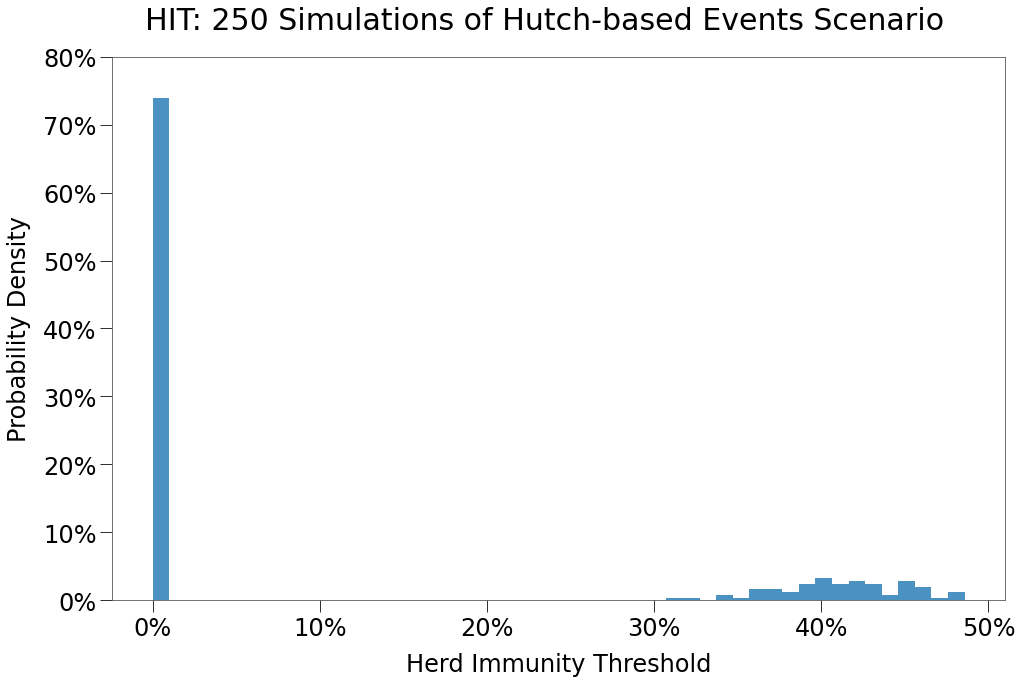

In [10]:
from rknot.notebook import curvehist
savepath = 'vids/us_w_load/events_hist'

labels = [None]
title = r'HIT: 250 Simulations of Hutch-based Events Scenario'
curvehist([res1[:,1]], labels, title=title, which='hit', savepath=savepath)

<img 
    src='https://storage.googleapis.com/rknotvids/us_w_load/events_hist.png'
    alt='Drawing' style='width: 700px;' align='center'
/>

#### 2. Gates ####
We will replicate the [SIR Gates scenario](sir.ipynb#6.-Gates) by creating a separate group of of the elderly that are isolated within gate. This is meant to simulate care homes or assisted living centers.

One augmentation is made to create a small group of care home workers that will reqularly enter the gate to service residents (in addition to visits by other subjects). The care home workers will be drawn from the `20-49` age group.

The new groups are:

* `group2b`
    * population of 66
    * Assuming [2.2MM care home workers in the United States](http://phinational.org/wp-content/uploads/legacy/phi-home-care-workers-key-facts.pdf) out of a population of 330MM.
    * remaining attributes similar to `20-49`
    * events individual travel events for half the group, recurring every day
* `group4a`
    * population of 600 (2/3s of `group4`) 
    * IFR of 4.2%
    * remaining attributes mathcing prior `70+` group
* `group4b`
    * population of 300 (1/3rd of `group4`)
    * IFR of 7.8%
    * mover function `p-value` increased to .99
    * not eligible for any events

We have also adjusted the IFR on the basis that `group4b` is likely older and also probably more frail than `group4a`. IFRs approximate those found [here](https://www.publichealthontario.ca/-/media/documents/ncov/epi/2020/06/covid19-epi-case-identification-age-only-template.pdf?la=en).

We have also adjusted events in the event VBox to include the 5 groups that are not gated.

```python
from rknot import Sim, Chart

from rknot.dots.fhutch import tmr
from rknot.sims.us_w_load_18 import events

from rknot.dots.fhutch import tmr
from rknot.sims import us_w_load_18
from rknot.events import Travel

group1 = dict(
    name='0-19',
    n=2700,
    n_inf=0,
    ifr=0.00003,
    mover=.98,
)
group2a = dict(
    name='20-49',
    n=4034,
    n_inf=1,
    ifr=0.0002,
    mover=.98,
)
group2b = dict(
    name='HCW',
    n=66,
    n_inf=0,
    ifr=0.0002,
    mover=.98,
)
group3 = dict(
    name='50-69',
    n=2300,
    n_inf=1,
    ifr=0.005,
    mover=.98,
)
group4a = dict(
    name='70+',
    n=600,
    n_inf=0,
    ifr=0.042,
    mover=.98,
)
group4b = dict(
    name='70+G',
    n=300,
    n_inf=0,
    ifr=0.0683,
    mover=.99,
    box=[1,10,1,10],
    box_is_gated=True,
)
groups = [group1, group2a, group2b, group3, group4a, group4b]

for e in us_w_load_18.events:
    e.groups = [0,1,2,3,4]

visit = Travel(
    name='visit', xy=[1,1], start_tick=3, 
    groups=[1,3,4], capacity=1, duration=1, recurring=1
)

works = []
for i in range(group2b['n'] // 2):
    loc  = np.random.randint(1, 11, size=(2,)) 
    work = Travel(
        name=f'hcw-work-{i}', xy=loc, start_tick=1, 
        groups=[2], capacity=1, duration=1, recurring=1
    )
    works.append(work)

events_gated = [deepcopy(e) for e in events]

for e in events_gated:
    e.groups = [0,1,2,3,4]

events_gated = events_gated + [visit] + works

vbox = {'label': 'Events', 'box': 344}
params = {
  'groups': groups,
  'density': 1, 'days': 365, 
  'tmr_curve': tmr, 'vboxes': vbox,
  'events': us_w_load_18.events
}
sim = Sim(**params)
sim.run(dotlog=True)

chart = Chart(sim).to_html5_video()
```

In [4]:
if IMPORT:
    from rknot import Sim, Chart
    from rknot.sims import us_w_load_18

    modulereload(us_w_load_18)
    
    assert 'susf' not in us_w_load_18.groups[1]

In [4]:
from rknot import Sim
from rknot.sims import us_w_load_18
from rknot.helpers import ShelfHelp
from rknot.dots.fhutch import tmr

file = 'tests/data/load_gates'
key = 'load_gates_iters_RESULTS'
simbase = us_w_load_18.__name__.split('.')[-1]

if False:
    from rknot.helpers import looper
    
    n = 250
    contacts, nsecs, results, exceptions = looper(
        n, sterile=False, **us_w_load_18.params_gated
    )

try:
    tgt_R0 = 1.8
    mu = 4
    theta = 40
    args = n, contacts, nsecs, results, tmr, simbase, tgt_R0, mu, theta
except NameError:
    args = []
with ShelfHelp(file, key) as sh:
    n, tmr, c1, nsecs, res1 = sh.values(*args)

This data has multiple iterations.
Append to the existing data?
Proceed? (Y/n)
n
Do you want to overwrite the existing data?
(Y/n)
n
Return existing data?
(Y/n)



In [6]:
import numpy as np

from rknot.notebook import curve_table, md

i_table = [0,1,2,-1]
res1 = np.around(res1, 3)
res1 = res1[:, i_table]

persec = np.array([(np.sum(res1[:,1] == 0) / res1.shape[0])])
means1 = np.concatenate((res1.mean(axis=0), persec))

means1_gt_0 = np.zeros(5)
for i in range(res1.shape[1]):
    exc = res1[:,i][np.argwhere(res1[:,i] >= 0.1).ravel()].mean()
    means1_gt_0[i] = exc

headers = ['Events', r'Events ex. 0 $R_0$'] 
args = [t for tup in zip(means1, means1_gt_0) for t in tup]
    
md(curve_table(2, headers, args))

Average Values

|      | Events  | Events ex. 0 $R_0$   | 
| -------------|:-------------:|:-------------:| 
| Peak      |   11.1%|   41.1%| 
| HIT       |   12.8%|   47.7%| 
| Total   |   15.4%|   57.1%| 
| Days to Peak   |   22.5|   34.4| 
| No Secondary  |   53.6%|   0.0%|

No handles with labels found to put in legend.


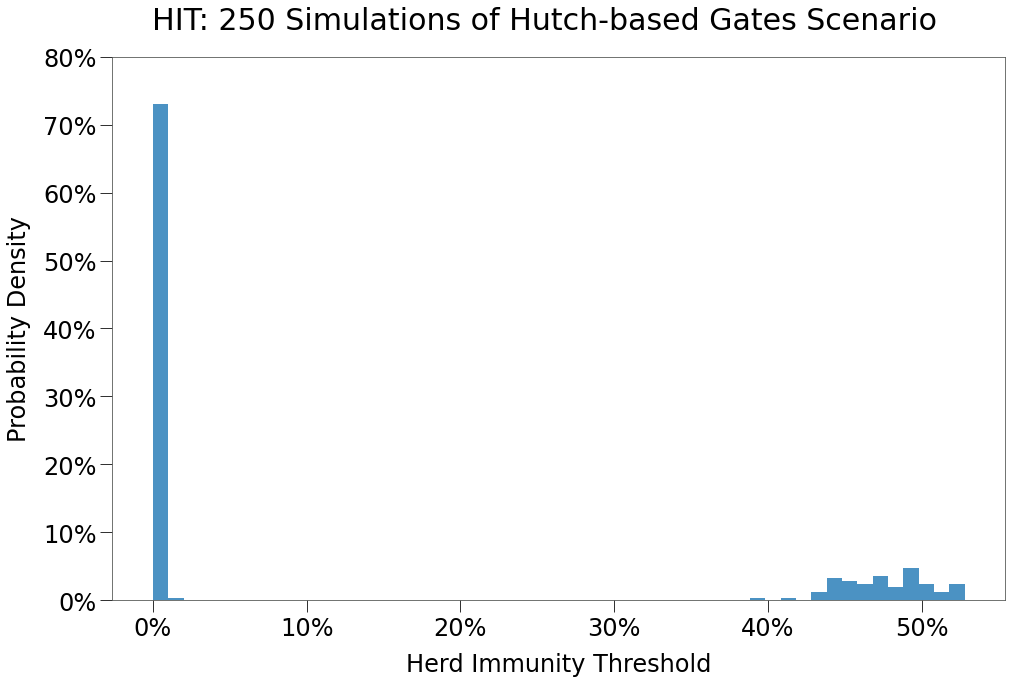

In [7]:
from rknot.notebook import curvehist
savepath = 'vids/us_w_load/gates_hist'

labels = [None]
title = r'HIT: 250 Simulations of Hutch-based Gates Scenario'
curvehist([res1[:,1]], labels, title=title, which='hit', savepath=savepath)

In [43]:
import ray
ray.shutdown()

In [1]:
%load_ext autoreload
%autoreload 2
RUN = True
if RUN:
    from rknot.sim import recycler
    from rknot.helpers import get_results
    from rknot.notebook import modulereload
    from rknot.sims import us_w_load_18
    
    modulereload(us_w_load_18)
    
    sim_cycler = recycler(100)
    while True:    
        sim = sim_cycler(pbar_leave=False, pbar=False, **us_w_load_18.params_gated)
        sim.run(dotlog=True, pbar_leave=False, pbar=False)

        res = get_results(sim)
        print (res)
        if .45 < res[1] < .50:
            print (res)
            break

[2.1e-03 2.1e-03 2.1e-03 0.0e+00 0.0e+00 0.0e+00 1.4e+01]
[6.e-04 6.e-04 6.e-04 0.e+00 0.e+00 0.e+00 8.e+00]
[0.0002 0.0002 0.0002 0.     0.     0.     0.    ]
[0.0002 0.0002 0.0002 0.     0.     0.     0.    ]
[3.e-04 3.e-04 3.e-04 0.e+00 0.e+00 0.e+00 6.e+00]
[3.51300000e-01 4.05100000e-01 5.09800000e-01 2.30000000e-03
 1.00000000e-02 4.51157317e-03 6.40000000e+01]
[3.74500000e-01 4.72600000e-01 5.61200000e-01 1.50000000e-03
 3.00000000e-02 2.67284391e-03 1.03000000e+02]
[3.74500000e-01 4.72600000e-01 5.61200000e-01 1.50000000e-03
 3.00000000e-02 2.67284391e-03 1.03000000e+02]


In [32]:
from datetime import datetime as dt
from rknot.helpers import picksave, pickload
file = 'vids/us_w_load/gates'

if SAVE:
    delattr(sim, 'server')
    delattr(sim, 'workers')
    sims = pickload(file)
    sims[dt.now()] = sim
    picksave(file, sims)

    sims = pickload(file)
    run_date, sim = sorted(sims.items())[-1] # Get the most recent saved sim
else:
    sims = pickload(file)
    run_date, sim = sorted(sims.items())[-1] # Get the most recent saved sim
    res = get_results(sim)

AttributeError: server

In [4]:
SAVE_CHARTS = True
if SAVE_CHARTS:
    from rknot import Chart
    PATH = 'vids/us_w_load/tests/'
    chart_params = dict(reso_format='web', dotsize=.1)
    chart = Chart(sim, show_intro=True, show_restricted=True, **chart_params).save(PATH + 'gates.mp4')

/Users/spindicate/Documents/programming/rknot/rknot/animate/main.py:226: UserWarning: When `reso_format='web', you must call the save method at the same time as instantiating the object, or it will hang.
  warnings.warn(msg)


<video width='705' height='340'
    src='https://storage.googleapis.com/rknotvids/baseus/gates.mp4' controls>Video Failed to Load</video>

In [4]:
from rknot.notebook import md, results_table
md(results_table(res))

Results: 

|      |      | 
| ------------- |:-------------:| 
| Peak      |   37.5% | 
| HIT      | 47.3%      | 
| Total      | 56.1%      | 
| Fatalities | 0.15%      | 
| % > 70 | 3.0%      | 
| IFR | 0.27%        | 
| Days to Peak |   103 | 


#### 3. Restrict Large Gatherings ####

As with the [SIR Model simulations](sir.ipynb#Policy), we can explore the impact of policy restrictions on spread in our more sophisticated environment. First, we will restrict large gatherings.

We'll again restrict gatherings with 10+ capacity.

We assume this policy is implemented on day 30. The restriction will last for 120 days.

With a gamma distributed contact distribution, a very large number of contacts can be eliminated by eliminating just a small fraction of events.

In [36]:
import numpy as np
caps = np.array([e.capacity for e in us_w_load_18.events_gated])
n_events = caps.shape[0]
n_events_gt10 = np.bincount(caps)[10:].sum()
print (n_events, n_events_gt10, np.around(n_events_gt10 / n_events, 2))

9176 1639 0.18


Here we see that events with capacity 10+ represent just 18% of all events.

In [39]:
counts, bins = np.histogram(caps-1, bins=np.arange(max(caps) + 1))
contacts = counts*(np.arange(counts.shape[0])+1)
c_gt10 = np.sum(contacts[10:]*np.arange(10, contacts[10:].shape[0] + 10))
c = np.sum(contacts*np.arange(contacts.shape[0]))
print (c, c_gt10, np.around(c_gt10 / c, 2))

992180 831318 0.84


And that these events represent 84% of all contacts generated by those events.

```python
from rknot.events import Restriction

large_gatherings = Restriction(
    name='large', start_tick=30, duration=120, criteria={'capacity': 10}
)
events_w_res = events_gated + [large_gatherings]

params = {
  'groups': groups,
  'density': 1, 'days': 365, 
  'tmr_curve': tmr, 'vboxes': vbox,
  'events': us_w_load_18.events
}
sim = Sim(**params)
sim.run(dotlog=True)

chart = Chart(sim).to_html5_video()
```

In [ ]:
from rknot import Sim
from rknot.sims import us_w_load_18
from rknot.notebook import modulereload
from rknot.helpers import ShelfHelp
from rknot.dots.fhutch import tmr

modulereload(us_w_load_18)

file = 'tests/data/load_large_gatherings'
key = 'load_large_gatherings_iters_RESULTS'
simbase = us_w_load_18.__name__.split('.')[-1]

if True:
    from rknot.helpers import looper
    from rknot.events import Restriction

    large_gatherings = Restriction(
        name='large', start_tick=30, duration=120, criteria={'capacity': 10}
    )
    events_w_res = us_w_load_18.events_gated + [large_gatherings]

    us_w_load_18.params_gated['events'] = events_w_res
    
    n = 2
    contacts, nsecs, results, exceptions = looper(
        n, sterile=False, **us_w_load_18.params_gated
    )

In [2]:
try:
    tgt_R0 = 1.8
    mu = 4
    theta = 40
    args = n, contacts, nsecs, results, tmr, simbase, tgt_R0, mu, theta
except NameError:
    args = []
with ShelfHelp(file, key) as sh:
    n, tmr, c1, nsecs, res1 = sh.values(*args)

This data has multiple iterations.
Append to the existing data?
Proceed? (Y/n)
n
Do you want to overwrite the existing data?
(Y/n)
n
Return existing data?
(Y/n)
Y


In [3]:
import numpy as np

from rknot.notebook import curve_table, md

i_table = [0,1,2,-1]
res1 = np.around(res1, 3)
res1 = res1[:, i_table]

persec = np.array([(np.sum(res1[:,1] == 0) / res1.shape[0])])
means1 = np.concatenate((res1.mean(axis=0), persec))

means1_gt_0 = np.zeros(5)
for i in range(res1.shape[1]):
    exc = res1[:,i][np.argwhere(res1[:,i] >= 0.1).ravel()].mean()
    means1_gt_0[i] = exc

headers = ['Events', r'Events ex. 0 $R_0$'] 
args = [t for tup in zip(means1, means1_gt_0) for t in tup]
    
md(curve_table(2, headers, args))

<ipython-input-3-ad1eb80215e1>:14: RuntimeWarning: Mean of empty slice.
  exc = res1[:,i][np.argwhere(res1[:,i] >= 0.1).ravel()].mean()
/Users/spindicate/Documents/programming/envs/r0env/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Average Values

|      | Events  | Events ex. 0 $R_0$   | 
| -------------|:-------------:|:-------------:| 
| Peak      |   2.2%|   nan%| 
| HIT       |   2.2%|   nan%| 
| Total   |   2.2%|   nan%| 
| Days to Peak   |   17.5|   35.0| 
| No Secondary  |   50.0%|   0.0%|

No handles with labels found to put in legend.


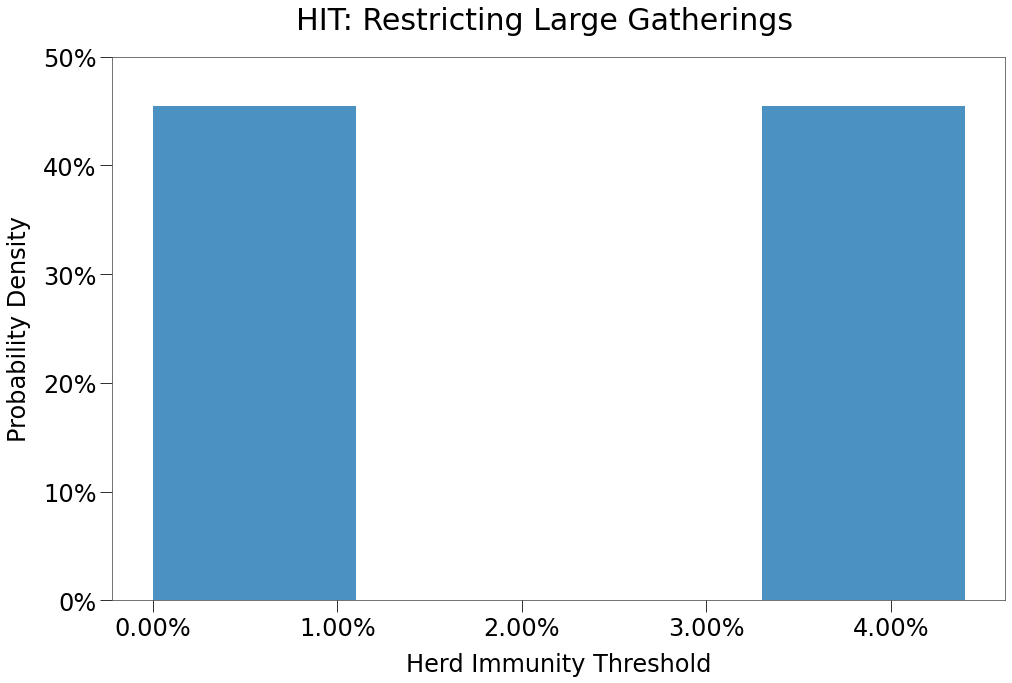

In [4]:
from rknot.notebook import curvehist
savepath = 'vids/us_w_load/large_gatherings_hist'

labels = [None]
title = r'HIT: Restricting Large Gatherings'
curvehist([res1[:,1]], labels, title=title, which='hit', savepath=savepath)

In [12]:
%load_ext autoreload
%autoreload 2
RUN = True
if RUN:
    from rknot.sim import recycler
    from rknot.helpers import get_results
    from rknot.notebook import modulereload
    from rknot.sims import us_w_load_18
    
    modulereload(us_w_load_18)
    
    large_gatherings = Restriction(
        name='large', start_tick=30, duration=120, criteria={'capacity': 10}
    )
    events_w_res = us_w_load_18.events_gated + [large_gatherings]

    us_w_load_18.params_gated['events'] = events_w_res

    sim_cycler = recycler(100)
    while True:    
        sim = sim_cycler(pbar_leave=False, pbar=False, **us_w_load_18.params_gated)
        sim.run(dotlog=True, pbar_leave=False, pbar=False)

        res = get_results(sim)
        break
        if .45 < res[1] < .50:
            print (res)
            break    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from datetime import datetime as dt
from rknot.helpers import picksave, pickload
file = 'vids/us_w_load/large_gatherings'
SAVE = True
if SAVE:
    delattr(sim, 'server')
    delattr(sim, 'workers')
    sims = pickload(file)
    sims[dt.now()] = sim
    picksave(file, sims)

    sims = pickload(file)
    run_date, sim = sorted(sims.items())[-1] # Get the most recent saved sim
else:
    sims = pickload(file)
    run_date, sim = sorted(sims.items())[-1] # Get the most recent saved sim
    res = get_results(sim)

/Users/spindicate/Documents/programming/rknot/rknot/animate/main.py:226: UserWarning: When `reso_format='web', you must call the save method at the same time as instantiating the object, or it will hang.
  warnings.warn(msg)


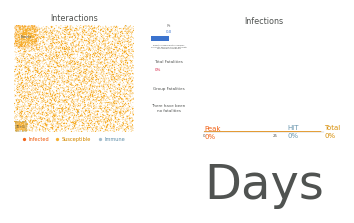

In [15]:
if SAVE_CHARTS:
    from rknot import Chart
    PATH = 'vids/us_w_load/tests/'
    chart_params = dict(reso_format='web', dotsize=.1)
    chart = Chart(sim, show_intro=True, show_restricted=True, **chart_params).save(PATH + 'large_gatherings.mp4')

<video width='705' height='340'
    src='https://storage.googleapis.com/rknotvids/us_w_load/large_gatherings.mp4' controls>Video Failed to Load</video>
    

In [16]:
from rknot.notebook import md, results_table
md(results_table(res))

Results: 

|      |      | 
| ------------- |:-------------:| 
| Peak      |   0.2% | 
| HIT      | 0.2%      | 
| Total      | 0.2%      | 
| Fatalities | 0.00%      | 
| % > 70 | nan%      | 
| IFR | 0.00%        | 
| Days to Peak |   12 | 


#######################

#### 4. Social Distancing ####

We will now investigate the impact of social distancing measures [as outlined here](sir.ipynb#2.-Social-Distancing).

We provice `tmfs` to each age group, representing the adherence to and impact of various tactics including 6-feet of distance, masks, hand sanitizer, etc.

The policy measure is implemented on day 30 and maintained for 120 days.

```python
from rknot.events import SocialDistancing as SD

sd = SD(
    name='all', tmfs=[.8,.8,.7,.65,.5], 
    groups=[0,1,2,3,4], start_tick=30, duration=120
)
events_w_res = events_gated + [sd]
params = {
  'groups': groups,
  'density': 1, 'days': 365, 
  'tmr_curve': tmr, 'vboxes': vbox,
  'events': us_w_load_18.events
}
sim = Sim(**params)
sim.run()

chart = Chart(sim, use_init_func=True)
chart.animate.to_html5_video()
```

In [18]:
from rknot import Sim
from rknot.sims import us_w_load_18
from rknot.notebook import modulereload
from rknot.helpers import ShelfHelp
from rknot.dots.fhutch import tmr

modulereload(us_w_load_18)

file = 'tests/data/load_sd'
key = 'load_sd_iters_RESULTS'
simbase = us_w_load_18.__name__.split('.')[-1]

if True:
    from rknot.helpers import looper
    from rknot.events import Restriction, SocialDistancing as SD

    sd = SD(
        name='all', tmfs=[.8,.8,.7,.65,.5], 
        groups=[0,1,2,3,4], start_tick=30, duration=120
    )
    events_w_res = us_w_load_18.events_gated + [sd]

    us_w_load_18.params_gated['events'] = events_w_res
    
    n = 2
    contacts, nsecs, results, exceptions = looper(
        n, sterile=False, **us_w_load_18.params_gated
    )

try:
    tgt_R0 = 1.8
    mu = 4
    theta = 40
    args = n, contacts, nsecs, results, tmr, simbase, tgt_R0, mu, theta
except NameError:
    args = []
with ShelfHelp(file, key) as sh:
    n, tmr, c1, nsecs, res1 = sh.values(*args)

shouldnt be here



/Users/spindicate/Documents/programming/rknot/rknot/helpers/helpers.py:192: RuntimeWarning: invalid value encountered in double_scalars
  _70 = _70/group_deps.sum()
/Users/spindicate/Documents/programming/rknot/rknot/helpers/shelfhelp.py:107: UserWarning: Heads up: this key does not exist and so you are SAVING A NEW ONE
  warnings.warn(msg)
/Users/spindicate/Documents/programming/rknot/rknot/helpers/shelfhelp.py:59: RuntimeWarning: invalid value encountered in double_scalars
  theta = contacts.var() / contacts.mean()


In [19]:
import numpy as np

from rknot.notebook import curve_table, md

i_table = [0,1,2,-1]
res1 = np.around(res1, 3)
res1 = res1[:, i_table]

persec = np.array([(np.sum(res1[:,1] == 0) / res1.shape[0])])
means1 = np.concatenate((res1.mean(axis=0), persec))

means1_gt_0 = np.zeros(5)
for i in range(res1.shape[1]):
    exc = res1[:,i][np.argwhere(res1[:,i] >= 0.1).ravel()].mean()
    means1_gt_0[i] = exc

headers = ['SD', r'SD ex. 0 $R_0$'] 
args = [t for tup in zip(means1, means1_gt_0) for t in tup]
    
md(curve_table(2, headers, args))

<ipython-input-19-d8d7bf501572>:14: RuntimeWarning: Mean of empty slice.
  exc = res1[:,i][np.argwhere(res1[:,i] >= 0.1).ravel()].mean()
/Users/spindicate/Documents/programming/envs/r0env/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Average Values

|      | SD  | SD ex. 0 $R_0$   | 
| -------------|:-------------:|:-------------:| 
| Peak      |   4.1%|   nan%| 
| HIT       |   4.8%|   nan%| 
| Total   |   5.5%|   11.1%| 
| Days to Peak   |   27.5|   27.5| 
| No Secondary  |   50.0%|   0.0%|

No handles with labels found to put in legend.


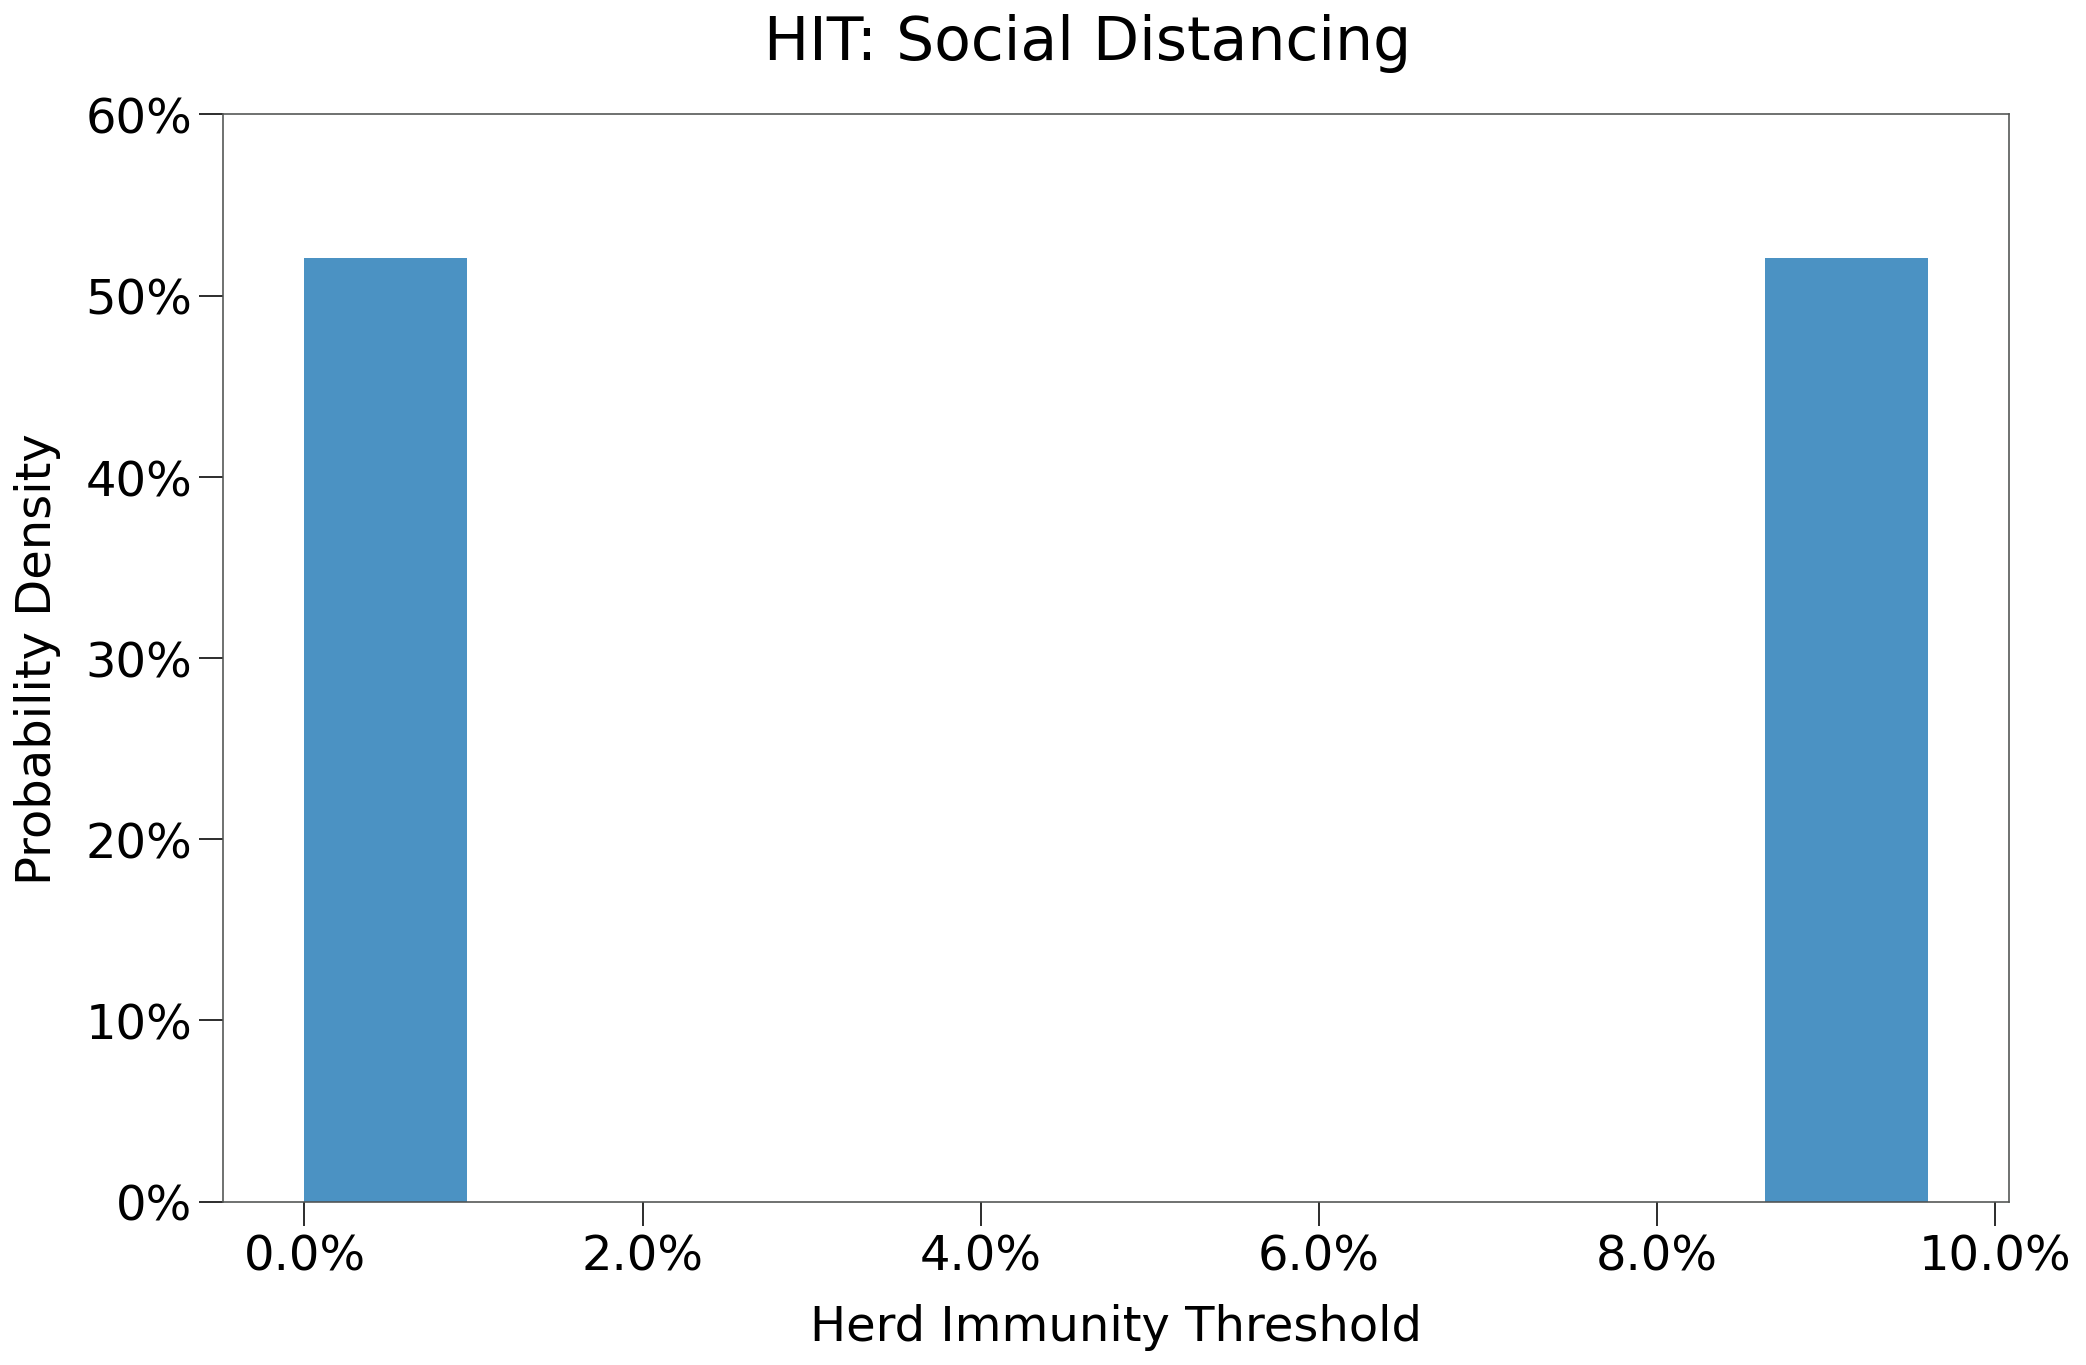

In [20]:
from rknot.notebook import curvehist
savepath = 'vids/us_w_load/social_distancing'

labels = [None]
title = r'HIT: Social Distancing'
curvehist([res1[:,1]], labels, title=title, which='hit', savepath=savepath)

In [21]:
%load_ext autoreload
%autoreload 2

if RUN:
    from rknot.sim import recycler
    from rknot.helpers import get_results
    from rknot.notebook import modulereload
    from rknot.sims import us_w_load_18
    
    modulereload(us_w_load_18)
    
    sd = SD(
        name='all', tmfs=[.8,.8,.7,.65,.5], 
        groups=[0,1,2,3,4], start_tick=30, duration=120
    )
    events_w_res = us_w_load_18.events_gated + [sd]

    us_w_load_18.params_gated['events'] = events_w_res

    sim_cycler = recycler(100)
    while True:    
        sim = sim_cycler(pbar_leave=False, pbar=False, **us_w_load_18.params_gated)
        sim.run(dotlog=True, pbar_leave=False, pbar=False)
        
        res = get_results(sim)
        break
        if .45 < res[1] < .50:
            print (res)
            break    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
file = 'vids/us_w_load/social_distancing'
with open(file, 'wb') as thefile:
    pickle.dump({}, thefile)

In [23]:
from datetime import datetime as dt
from rknot.helpers import picksave, pickload
file = 'vids/us_w_load/social_distancing'

if SAVE:
    delattr(sim, 'server')
    delattr(sim, 'workers')
    sims = pickload(file)
    sims[dt.now()] = sim
    picksave(file, sims)

    sims = pickload(file)
    run_date, sim = sorted(sims.items())[-1] # Get the most recent saved sim
else:
    sims = pickload(file)
    run_date, sim = sorted(sims.items())[-1] # Get the most recent saved sim
    res = get_results(sim)

/Users/spindicate/Documents/programming/rknot/rknot/animate/main.py:226: UserWarning: When `reso_format='web', you must call the save method at the same time as instantiating the object, or it will hang.
  warnings.warn(msg)


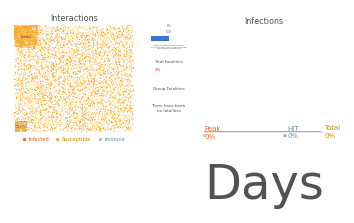

In [24]:
if SAVE_CHARTS:
    from rknot import Chart
    PATH = 'vids/us_w_load/tests/'
    chart_params = dict(reso_format='web', dotsize=.1)
    chart = Chart(sim, show_intro=True, show_restricted=True, **chart_params).save(PATH + 'social_distancing.mp4')

<video width='705' height='340'
    src='https://storage.googleapis.com/rknotvids/us_w_load/social_distancing.mp4' controls>Video Failed to Load</video>

In [25]:
from rknot.notebook import md, results_table
md(results_table(res))

Results: 

|      |      | 
| ------------- |:-------------:| 
| Peak      |   0.1% | 
| HIT      | 0.1%      | 
| Total      | 0.1%      | 
| Fatalities | 0.00%      | 
| % > 70 | nan%      | 
| IFR | 0.00%        | 
| Days to Peak |   7 | 


#### 5. Restrict Elderly Visits ####

Again, as with the [SIR simulations](sir.ipybn#3.-Restrict-Elderly-Visits), we will restrict visits to the elderly, HOWEVER, care home workers will continue to have access.

The policy measure is implemented on day 30 and maintained for another 120 days. There will be no other restrictions.

```python
no_visits = Restriction(
    name='no_visits', start_tick=30, 
    duration=120, criteria={'name': 'visit'}
)
events_w_res = events_gated + [no_visits]
params = {
  'groups': groups,
  'density': 1, 'days': 365, 
  'tmr_curve': tmr, 'vboxes': vbox,
  'events': us_w_load_18.events
}
sim = Sim(**params)
sim.run()

chart = Chart(sim, use_init_func=True)
chart.animate.to_html5_video()
```

In [26]:
from rknot import Sim
from rknot.sims import us_w_load_18
from rknot.notebook import modulereload
from rknot.helpers import ShelfHelp
from rknot.dots.fhutch import tmr

modulereload(us_w_load_18)

file = 'tests/data/load_elderly'
key = 'load_elderly_iters_RESULTS'
simbase = us_w_load_18.__name__.split('.')[-1]

if True:
    from rknot.helpers import looper
    from rknot.events import Restriction

    no_visits = Restriction(
        name='no_visits', start_tick=30, 
        duration=120, criteria={'name': 'visit'}
    )
    events_w_res = us_w_load_18.events_gated + [no_visits]

    us_w_load_18.params_gated['events'] = events_w_res
    
    n = 2
    contacts, nsecs, results, exceptions = looper(
        n, sterile=False, **us_w_load_18.params_gated
    )

try:
    tgt_R0 = 1.8
    mu = 4
    theta = 40
    args = n, contacts, nsecs, results, tmr, simbase, tgt_R0, mu, theta
except NameError:
    args = []
with ShelfHelp(file, key) as sh:
    n, tmr, c1, nsecs, res1 = sh.values(*args)


shouldnt be here



/Users/spindicate/Documents/programming/rknot/rknot/helpers/helpers.py:192: RuntimeWarning: invalid value encountered in double_scalars
  _70 = _70/group_deps.sum()
/Users/spindicate/Documents/programming/rknot/rknot/helpers/shelfhelp.py:107: UserWarning: Heads up: this key does not exist and so you are SAVING A NEW ONE
  warnings.warn(msg)
/Users/spindicate/Documents/programming/rknot/rknot/helpers/shelfhelp.py:59: RuntimeWarning: invalid value encountered in double_scalars
  theta = contacts.var() / contacts.mean()


In [27]:
import numpy as np

from rknot.notebook import curve_table, md

i_table = [0,1,2,-1]
res1 = np.around(res1, 3)
res1 = res1[:, i_table]

persec = np.array([(np.sum(res1[:,1] == 0) / res1.shape[0])])
means1 = np.concatenate((res1.mean(axis=0), persec))

means1_gt_0 = np.zeros(5)
for i in range(res1.shape[1]):
    exc = res1[:,i][np.argwhere(res1[:,i] >= 0.1).ravel()].mean()
    means1_gt_0[i] = exc

headers = ['No Visits', r'No Visits ex. 0 $R_0$'] 
args = [t for tup in zip(means1, means1_gt_0) for t in tup]
    
md(curve_table(2, headers, args))

Average Values

|      | No Visits  | No Visits ex. 0 $R_0$   | 
| -------------|:-------------:|:-------------:| 
| Peak      |   21.9%|   43.9%| 
| HIT       |   24.5%|   49.0%| 
| Total   |   28.6%|   57.3%| 
| Days to Peak   |   29.5|   59.0| 
| No Secondary  |   50.0%|   0.0%|

No handles with labels found to put in legend.


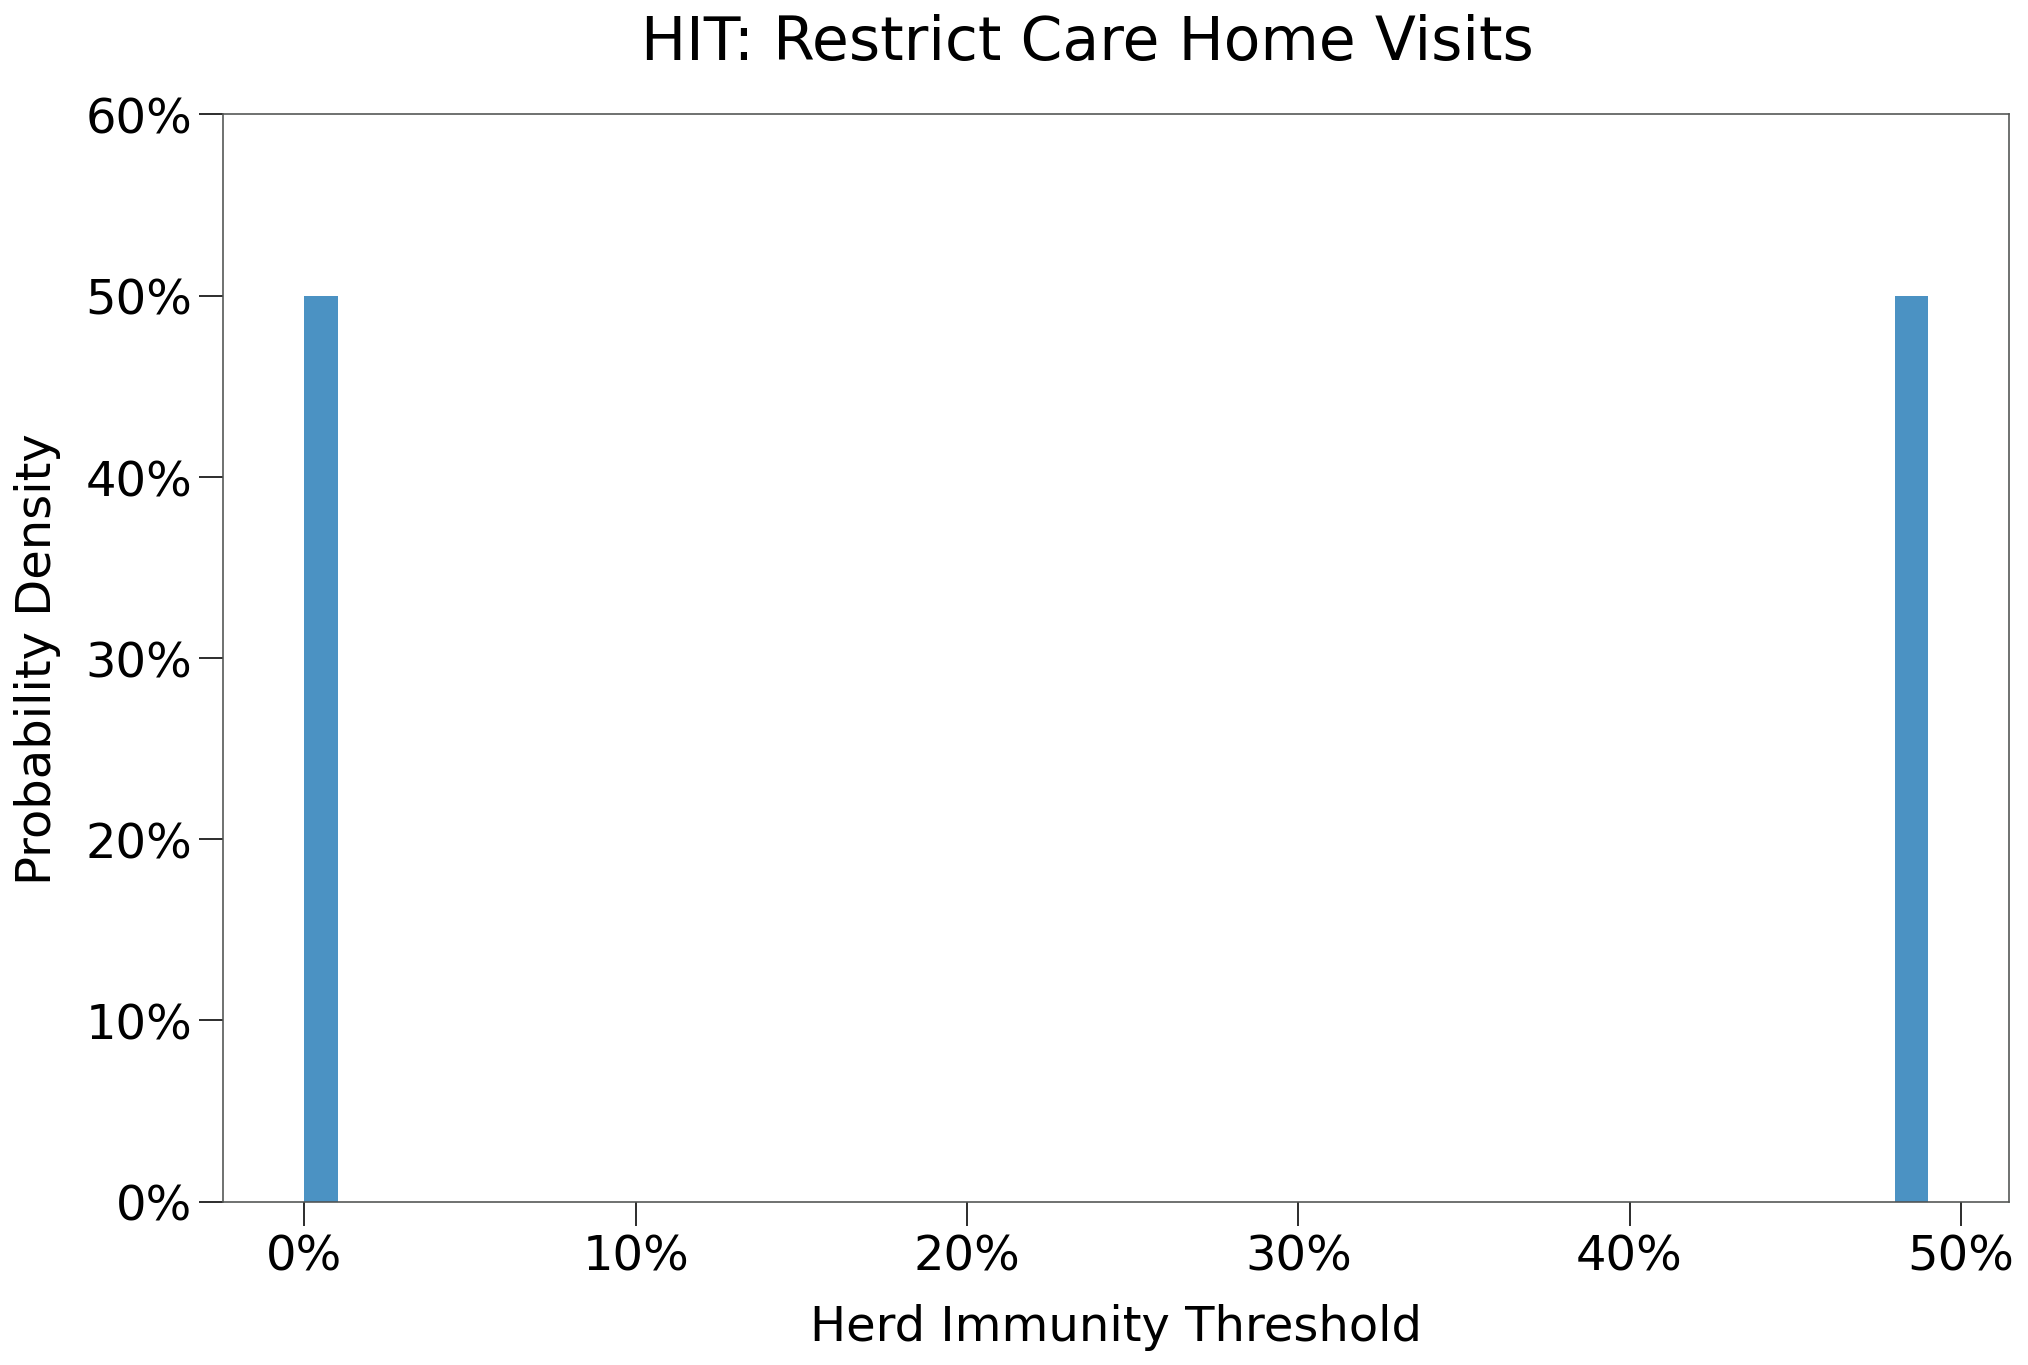

In [28]:
from rknot.notebook import curvehist
savepath = 'vids/us_w_load/elderly_visits'

labels = [None]
title = r'HIT: Restrict Care Home Visits'
curvehist([res1[:,1]], labels, title=title, which='hit', savepath=savepath)

In [29]:
%load_ext autoreload
%autoreload 2

if RUN:
    from rknot.sim import recycler
    from rknot.helpers import get_results
    from rknot.notebook import modulereload
    from rknot.sims import us_w_load_18
    from rknot.events import Restriction
    
    modulereload(us_w_load_18)
    
    no_visits = Restriction(
        name='no_visits', start_tick=30, 
        duration=120, criteria={'name': 'visit'}
    )
    events_w_res = us_w_load_18.events_gated + [no_visits]

    us_w_load_18.params_gated['events'] = events_w_res

    sim_cycler = recycler(100)
    while True:    
        sim = sim_cycler(pbar_leave=False, pbar=False, **us_w_load_18.params_gated)
        sim.run(dotlog=True, pbar_leave=False, pbar=False)
        
        res = get_results(sim)
        break
        if .45 < res[1] < .50:
            print (res)
            break    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
file = 'vids/us_w_load/elderly_visits'
with open(file, 'wb') as thefile:
    pickle.dump({}, thefile)

In [31]:
from datetime import datetime as dt
from rknot.helpers import picksave, pickload
file = 'vids/us_w_load/elderly_visits'

if SAVE:
    delattr(sim, 'server')
    delattr(sim, 'workers')
    sims = pickload(file)
    sims[dt.now()] = sim
    picksave(file, sims)

    sims = pickload(file)
    run_date, sim = sorted(sims.items())[-1] # Get the most recent saved sim
else:
    sims = pickload(file)
    run_date, sim = sorted(sims.items())[-1] # Get the most recent saved sim
    res = get_results(sim)

/Users/spindicate/Documents/programming/rknot/rknot/animate/main.py:226: UserWarning: When `reso_format='web', you must call the save method at the same time as instantiating the object, or it will hang.
  warnings.warn(msg)


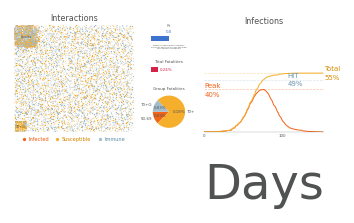

In [32]:
if SAVE_CHARTS:
    from rknot import Chart
    PATH = 'vids/us_w_load/tests/'
    chart_params = dict(reso_format='web', dotsize=.1)
    chart = Chart(sim, show_intro=True, show_restricted=True, **chart_params).save(PATH + 'elderly_visits.mp4')

<video width='705' height='340'
    src='https://storage.googleapis.com/rknotvids/us_w_load/elderly_visits.mp4' controls>Video Failed to Load</video>

In [33]:
from rknot.notebook import md, results_table
md(results_table(res))

Results: 

|      |      | 
| ------------- |:-------------:| 
| Peak      |   39.8% | 
| HIT      | 49.0%      | 
| Total      | 55.2%      | 
| Fatalities | 0.24%      | 
| % > 70 | 87.5%      | 
| IFR | 0.44%        | 
| Days to Peak |   76 | 


##############

#### 6. Social Distancing and Restrict Elderly Visits and Large Gatherings ####

Finally, we will combine the 3 approaches.

```python
large_gatherings = Restriction(
    name='large', start_tick=30, duration=120, criteria={'capacity': 10}
)
no_visits = Restriction(
    name='no_visits', start_tick=30, 
    duration=120, criteria={'name': 'visit'}
)
sd = SD(
    name='all', tmfs=[.8,.8,.7,.65,.5], 
    groups=[0,1,2,3,4], start_tick=30, duration=120
)
events_w_res = events_gated + [large_gatherings, no_visits, sd]

sim = Sim(groups=groups_gated, events=events_w_res, **params)
sim.run()

chart = Chart(sim, use_init_func=True)
chart.animate.to_html5_video()
```

In [36]:
from rknot import Sim
from rknot.sims import us_w_load_18
from rknot.notebook import modulereload
from rknot.helpers import ShelfHelp
from rknot.dots.fhutch import tmr

modulereload(us_w_load_18)

file = 'tests/data/load_multi'
key = 'load_multi_iters_RESULTS'
simbase = us_w_load_18.__name__.split('.')[-1]

if True:
    from rknot.helpers import looper
    from rknot.events import Restriction

    large_gatherings = Restriction(
        name='large', start_tick=30, duration=120, criteria={'capacity': 10}
    )
    no_visits = Restriction(
        name='no_visits', start_tick=30, 
        duration=120, criteria={'name': 'visit'}
    )
    sd = SD(
        name='all', tmfs=[.8,.8,.7,.65,.5], 
        groups=[0,1,2,3,4], start_tick=30, duration=120
    )
    events_w_res = us_w_load_18.events_gated + [large_gatherings, no_visits, sd]

    us_w_load_18.params_gated['events'] = events_w_res
    
    n = 2
    contacts, nsecs, results, exceptions = looper(
        n, sterile=False, **us_w_load_18.params_gated
    )

try:
    tgt_R0 = 1.8
    mu = 4
    theta = 40
    args = n, contacts, nsecs, results, tmr, simbase, tgt_R0, mu, theta
except NameError:
    args = []
with ShelfHelp(file, key) as sh:
    n, tmr, c1, nsecs, res1 = sh.values(*args)

shouldnt be here



/Users/spindicate/Documents/programming/rknot/rknot/helpers/shelfhelp.py:107: UserWarning: Heads up: this key does not exist and so you are SAVING A NEW ONE
  warnings.warn(msg)
/Users/spindicate/Documents/programming/rknot/rknot/helpers/shelfhelp.py:59: RuntimeWarning: invalid value encountered in double_scalars
  theta = contacts.var() / contacts.mean()


In [37]:
import numpy as np

from rknot.notebook import curve_table, md

i_table = [0,1,2,-1]
res1 = np.around(res1, 3)
res1 = res1[:, i_table]

persec = np.array([(np.sum(res1[:,1] == 0) / res1.shape[0])])
means1 = np.concatenate((res1.mean(axis=0), persec))

means1_gt_0 = np.zeros(5)
for i in range(res1.shape[1]):
    exc = res1[:,i][np.argwhere(res1[:,i] >= 0.1).ravel()].mean()
    means1_gt_0[i] = exc

headers = ['Multi', r'Multi ex. 0 $R_0$'] 
args = [t for tup in zip(means1, means1_gt_0) for t in tup]
    
md(curve_table(2, headers, args))

<ipython-input-37-f5cf9cc18c73>:14: RuntimeWarning: Mean of empty slice.
  exc = res1[:,i][np.argwhere(res1[:,i] >= 0.1).ravel()].mean()
/Users/spindicate/Documents/programming/envs/r0env/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Average Values

|      | Multi  | Multi ex. 0 $R_0$   | 
| -------------|:-------------:|:-------------:| 
| Peak      |   0.0%|   nan%| 
| HIT       |   0.0%|   nan%| 
| Total   |   0.0%|   nan%| 
| Days to Peak   |   3.5|   7.0| 
| No Secondary  |   100.0%|   0.0%|

ValueError: `bins` must be positive, when an integer

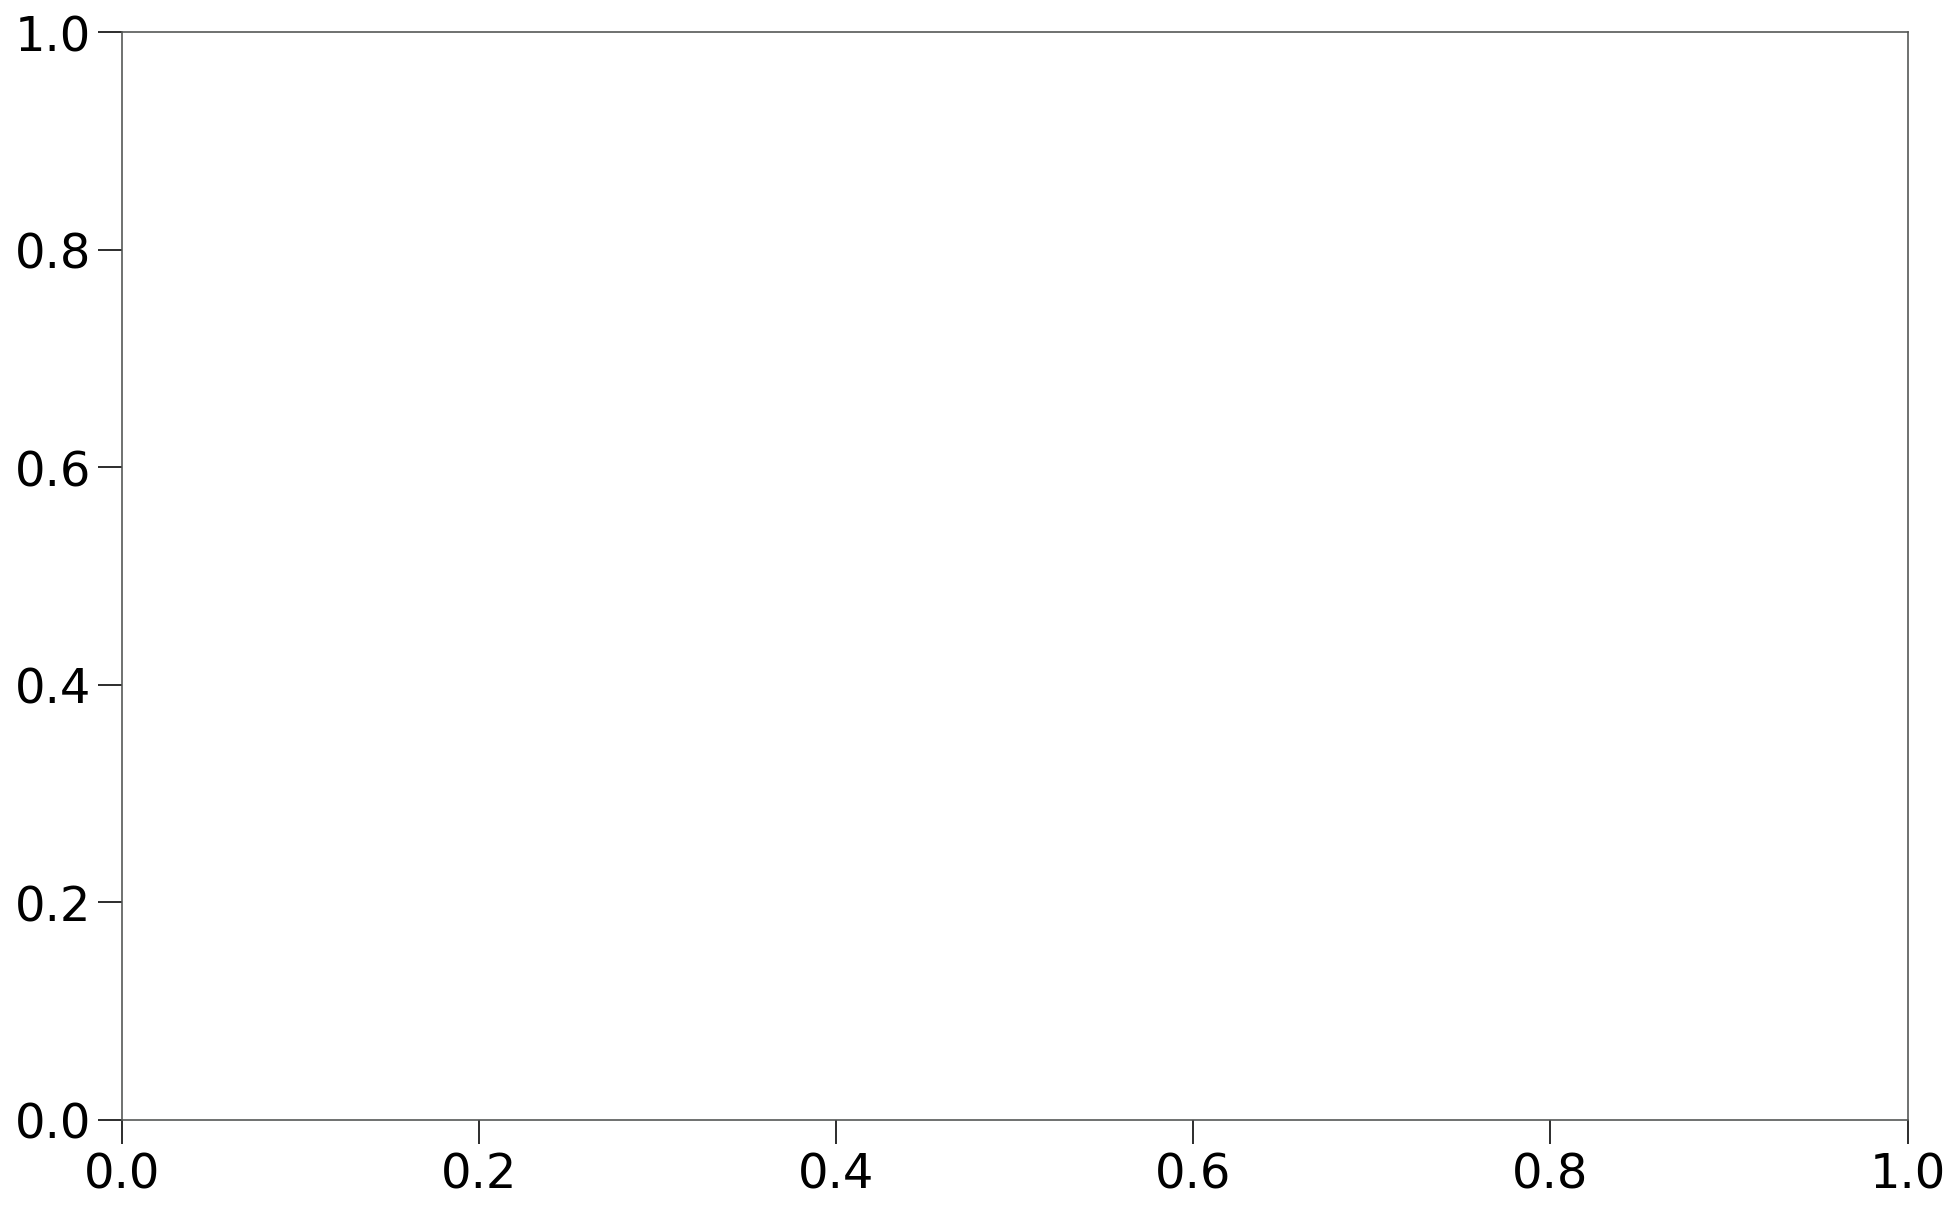

In [38]:
from rknot.notebook import curvehist
savepath = 'vids/us_w_load/elderly_visits'

labels = [None]
title = r'HIT: Multiple Restrictions'
curvehist([res1[:,1]], labels, title=title, which='hit', savepath=savepath)

In [ ]:
%load_ext autoreload
%autoreload 2

if RUN:
    from rknot.sim import recycler
    from rknot.helpers import get_results
    from rknot.notebook import modulereload
    from rknot.sims import us_w_load_18
    from rknot.events import Restriction
    
    modulereload(us_w_load_18)
    
    large_gatherings = Restriction(
        name='large', start_tick=30, duration=120, criteria={'capacity': 10}
    )
    no_visits = Restriction(
        name='no_visits', start_tick=30, 
        duration=120, criteria={'name': 'visit'}
    )
    sd = SD(
        name='all', tmfs=[.8,.8,.7,.65,.5], 
        groups=[0,1,2,3,4], start_tick=30, duration=120
    )
    events_w_res = us_w_load_18.events_gated + [large_gatherings, no_visits, sd]

    us_w_load_18.params_gated['events'] = events_w_res

    sim_cycler = recycler(100)
    while True:    
        sim = sim_cycler(pbar_leave=False, pbar=False, **us_w_load_18.params_gated)
        sim.run(dotlog=True, pbar_leave=False, pbar=False)
        
        res = get_results(sim)
        break
        if .45 < res[1] < .50:
            print (res)
            break    

In [ ]:
file = 'vids/us_w_load/multi'
with open(file, 'wb') as thefile:
    pickle.dump({}, thefile)

In [ ]:
from datetime import datetime as dt
from rknot.helpers import picksave, pickload
file = 'vids/us_w_load/multi'

if SAVE:
    delattr(sim, 'server')
    delattr(sim, 'workers')
    sims = pickload(file)
    sims[dt.now()] = sim
    picksave(file, sims)

    sims = pickload(file)
    run_date, sim = sorted(sims.items())[-1] # Get the most recent saved sim
else:
    sims = pickload(file)
    run_date, sim = sorted(sims.items())[-1] # Get the most recent saved sim
    res = get_results(sim)

/Users/spindicate/Documents/programming/rknot/rknot/animate/main.py:226: UserWarning: When `reso_format='web', you must call the save method at the same time as instantiating the object, or it will hang.
  warnings.warn(msg)


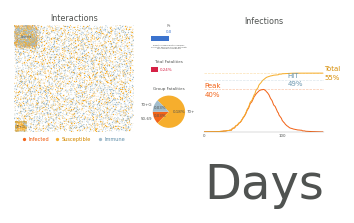

In [39]:
if SAVE_CHARTS:
    from rknot import Chart
    PATH = 'vids/us_w_load/tests/'
    chart_params = dict(reso_format='web', dotsize=.1)
    chart = Chart(sim, show_intro=True, show_restricted=True, **chart_params).save(PATH + 'multi.mp4')

<video width='705' height='340'
    src='https://storage.googleapis.com/rknotvids/us_w_load/multi.mp4' controls>Video Failed to Load</video>

In [40]:
from rknot.notebook import md, results_table
md(results_table(res))

Results: 

|      |      | 
| ------------- |:-------------:| 
| Peak      |   39.8% | 
| HIT      | 49.0%      | 
| Total      | 55.2%      | 
| Fatalities | 0.24%      | 
| % > 70 | 87.5%      | 
| IFR | 0.44%        | 
| Days to Peak |   76 | 


<video width='705' height='340'
    src='https://storage.googleapis.com/rknotvids/baseus/sd_%26_no_large_%26_no_visits.mp4' controls>Video Failed to Load</video>

##############

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [ ]:
from rknot.helpers import move_to_doc_folder
move_to_doc_folder('load.ipynb')